<a href="https://colab.research.google.com/github/aycaaozturk/Image-Based-Detection-of-Nail-Melanoma-Using-Deep-Learning-Techniques/blob/main/YOLO_Bounding_Box_Nail_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip list | grep torch

torch                                    2.9.0+cu126
torchao                                  0.10.0
torchaudio                               2.9.0+cu126
torchdata                                0.11.0
torchsummary                             1.5.1
torchtune                                0.6.1
torchvision                              0.24.0+cu126


In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.8 MB/s eta 0:00:00


In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 38.5/235.7 GB disk)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


This part of the code detects nail regions on the image. Detected nails (cropped nail regions) are saved in another directory.

In [ ]:
import os
import cv2
from ultralytics import YOLO

from google.colab import drive
drive.mount('/content/drive')

# Load your trained model
model = YOLO("/content/drive/My Drive/YOLO_myModel/best.pt")



# Input and output folders

#input_folder = ["/content/drive/My Drive/YOLO_myModel/All_Nails_for_BB"]
#output_folder =  "/content/drive/My Drive/YOLO_myModel/Results_all"
#crops_folder = "/content/drive/My Drive/YOLO_myModel/Cropped_all"

input_folder = ["/content/drive/My Drive/uniklinik/nailwue"]
output_folder =  "/content/drive/My Drive/uniklinik/boundingBoxResults"
crops_folder = "/content/drive/My Drive/uniklinik/cropped"




os.makedirs(output_folder, exist_ok=True)

# Loop through all images in the folder
for f in input_folder:
    for filename in os.listdir(f):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(f, filename)

            # Run bounding box detection with confidence threshol
            results = model(img_path, conf=0.3)

            # Get annotated image
            annotated = results[0].plot()

            # Save result to output folder with same filename
            save_path = os.path.join(output_folder, filename)
            cv2.imwrite(save_path, annotated)

            boxes = results[0].boxes  # all detections
            img = cv2.imread(img_path)

            for i, box in enumerate(boxes):
                # Get coordinates and detected class
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                cls_id = int(box.cls[0].item())
                cls_name = results[0].names[cls_id]

                # Crop detected region
                crop = img[y1:y2, x1:x2]

                # Make class specific folder
                class_folder = os.path.join(crops_folder, cls_name)
                os.makedirs(class_folder, exist_ok=True)

                # Save cropped image
                crop_filename = f"{os.path.splitext(filename)[0]}_obj{i+1}.jpg"
                crop_path = os.path.join(class_folder, crop_filename)
                cv2.imwrite(crop_path, crop)

            print(f"Processed: {filename} -> {save_path}")

print("✅ All images processed. Results saved in:", output_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

image 1/1 /content/drive/My Drive/uniklinik/nailwue/NAILwue_14_(3).jpg: 448x640 1 nail, 97.9ms
Speed: 12.5ms preprocess, 97.9ms inference, 39.5ms postprocess per image at shape (1, 3, 448, 640)
Processed: NAILwue_14_(3).jpg -> /content/drive/My Drive/uniklinik/boundingBoxResults/NAILwue_14_(3).jpg

image 1/1 /content/drive/My Drive/uniklinik/nailwue/NAILwue_14_(2).jpg: 448x640 1 nail, 7.0ms
Speed: 3.3ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Processed: NAILwue_14_(2).jpg -> /content/drive/My Drive/uniklinik/boundingBoxResults/NAILwue_14_(2).jpg

image 1/1 /content/drive/My Drive/uniklinik/nailwue/NAILwue_14_(1).jpg: 448x640 4 nails, 7.1ms
Speed: 3.5ms preprocess, 7.1ms inference, 6.1ms postprocess per image at shape (1, 3, 448, 640)
Processed: NAILwue_14_(1).jpg -> /content/drive/My Drive/uniklinik/boundingBoxResul

This part of the code resizes the cropped (detected) nails and adds black paddings around the image if necessary. The new size is: 224 x 224. The cropped images are saved in another directory.

In [ ]:
import cv2
import numpy as np
import os

def resize_with_aspect_ratio(image_path, output_path, target_size=224):
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f" Could not read {image_path}")
        return

    h, w = img.shape[:2]                 #height and width
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)  #adjust height and widht to target size

    # Resize while keeping aspect ratio
    resized = cv2.resize(img, (new_w, new_h))

    # Create square background
    result = np.zeros((target_size, target_size, 3), dtype=np.uint8)

    # Center the resized image
    x_offset = (target_size - new_w) // 2
    y_offset = (target_size - new_h) // 2
    result[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

    cv2.imwrite(output_path, result)


def resize_all_images(input_folder, output_folder, target_size=224):
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(input_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            resize_with_aspect_ratio(input_path, output_path, target_size)
            print(f"✅ Resized {filename}")


# Example usage
#resize_all_images("/content/drive/My Drive/yolov8 format all datasets/cropped_other/nail", "/content/drive/My Drive/yolov8 format all datasets/cropped_resized_other", target_size=224)


resize_all_images("/content/drive/My Drive/uniklinik/cropped/nail", "/content/drive/My Drive/uniklinik/cropped_resized", target_size=224)

✅ Resized NAILwue_14_(3)_obj1.jpg
✅ Resized NAILwue_14_(2)_obj1.jpg
✅ Resized NAILwue_14_(1)_obj1.jpg
✅ Resized NAILwue_14_(1)_obj2.jpg
✅ Resized NAILwue_14_(1)_obj3.jpg
✅ Resized NAILwue_14_(1)_obj4.jpg
✅ Resized NAILwue_13_(6)_obj1.jpg
✅ Resized NAILwue_15_(1)_obj1.jpg
✅ Resized NAILwue_15_(1)_obj2.jpg
✅ Resized NAILwue_15_(1)_obj3.jpg
✅ Resized NAILwue_15_(1)_obj4.jpg
✅ Resized NAILwue_15_(1)_obj5.jpg
✅ Resized NAILwue_14_(6)_obj1.jpg
✅ Resized NAILwue_14_(5)_obj1.jpg
✅ Resized NAILwue_14_(4)_obj1.jpg
✅ Resized NAILwue_16_(1)_obj1.jpg
✅ Resized NAILwue_16_(1)_obj2.jpg
✅ Resized NAILwue_16_(1)_obj3.jpg
✅ Resized NAILwue_16_(1)_obj4.jpg
✅ Resized NAILwue_16_(1)_obj5.jpg
✅ Resized NAILwue_15_(4)_obj1.jpg
✅ Resized NAILwue_15_(3)_obj1.jpg
✅ Resized NAILwue_15_(2)_obj1.jpg
✅ Resized NAILwue_15_(2)_obj2.jpg
✅ Resized NAILwue_15_(2)_obj3.jpg
✅ Resized NAILwue_16_(5)_obj1.jpg
✅ Resized NAILwue_16_(5)_obj2.jpg
✅ Resized NAILwue_16_(5)_obj3.jpg
✅ Resized NAILwue_16_(5)_obj4.jpg
✅ Resized NAIL

This part of the code calculates the confidence score distribution (mean, median, standard deviation) of the detected nails for a statistical analysis.

Streaming output truncated to the last 5000 lines.
image 1/1 /content/drive/My Drive/binary classification/train/non_melanoma/healthy_IMG-20250825-WA0067_jpg.rf.fedeab3064e45d1dd4ac90450088f4e1_obj4.jpg: 640x640 1 nail, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
healthy_IMG-20250825-WA0067_jpg.rf.fedeab3064e45d1dd4ac90450088f4e1_obj4.jpg: mean confidence = 0.827

image 1/1 /content/drive/My Drive/binary classification/train/non_melanoma/healthy_normal_original_IMG-20230621-WA0070_jpg_08a482fb-da27-4615-ad68-41690d5b6bae_jpg.rf.00695c058decea80df8806d1d56dffd9_obj1.jpg: 640x640 1 nail, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
healthy_normal_original_IMG-20230621-WA0070_jpg_08a482fb-da27-4615-ad68-41690d5b6bae_jpg.rf.00695c058decea80df8806d1d56dffd9_obj1.jpg: mean confidence = 0.912

image 1/1 /content/drive/My Drive/binary classification/train/non_melanoma/healthy_IMG-

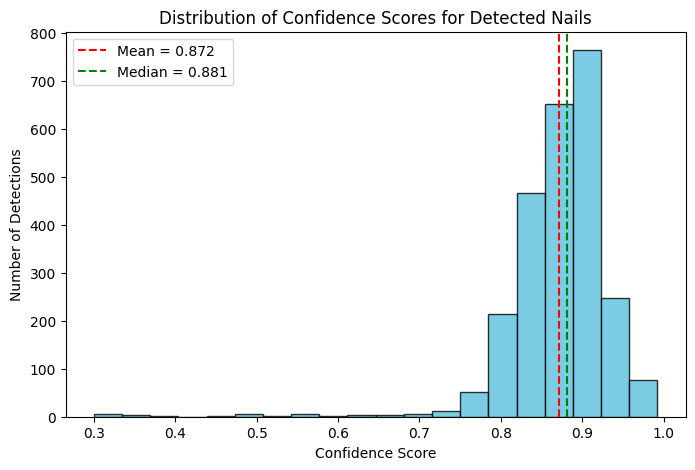

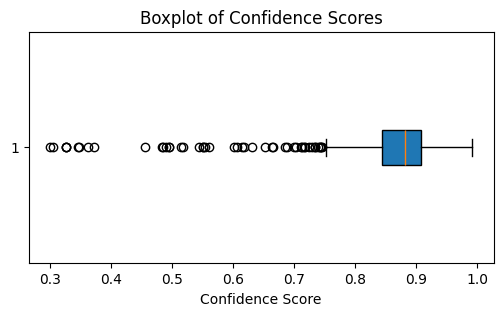

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load your trained model
model = YOLO("/content/drive/My Drive/YOLO_myModel/best.pt")

# Input and output folders
input_folder = ["/content/drive/My Drive/YOLO_myModel/All_Nails_for_BB"]
output_folder = "/content/drive/My Drive/YOLO_myModel/Conf"
os.makedirs(output_folder, exist_ok=True)

# For calculating the overall average confidence
all_confidences = []

# Process images
for f in input_folder:
    for filename in os.listdir(f):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(f, filename)
            results = model(img_path, conf=0.3)

            # Annotated output
            annotated = results[0].plot()
            save_path = os.path.join(output_folder, filename)
            cv2.imwrite(save_path, annotated)

            boxes = results[0].boxes
            img = cv2.imread(img_path)

            # Confidence extraction
            if len(boxes) > 0:
                confidences = boxes.conf.cpu().numpy()
                mean_conf = np.mean(confidences)
                all_confidences.extend(confidences)
                print(f"{filename}: mean confidence = {mean_conf:.3f}")
            else:
                print(f"{filename}: no detections")

print("✅ All images processed. Results saved in:", output_folder)

# Confidence statistics and visualization
if len(all_confidences) > 0:
    overall_mean_conf = np.mean(all_confidences)
    median_conf = np.median(all_confidences)
    std_conf = np.std(all_confidences)

    print(f"\n📊 Overall mean confidence: {overall_mean_conf:.4f}")
    print(f"📈 Median confidence: {median_conf:.4f}")
    print(f"📉 Std deviation: {std_conf:.4f}")

    # Histogram
    plt.figure(figsize=(8,5))
    plt.hist(all_confidences, bins=20, color='#5bc0de', edgecolor='black', alpha=0.8)
    plt.axvline(overall_mean_conf, color='red', linestyle='--', linewidth=1.5, label=f'Mean = {overall_mean_conf:.3f}')
    plt.axvline(median_conf, color='green', linestyle='--', linewidth=1.5, label=f'Median = {median_conf:.3f}')
    plt.title('Distribution of Confidence Scores for Detected Nails')
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Detections')
    plt.legend()
    plt.show()

    # Boxplot
    plt.figure(figsize=(6,3))
    plt.boxplot(all_confidences, vert=False, patch_artist=True)
    plt.title('Boxplot of Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.show()
else:
    print("No detections found in any image.")